# Confronto tra due medie

- Abbiamo un campione di 21 case per la città A e un campione di 21 case per la città B.
- Vogliamo capire se i prezzi delle abitazioni nelle due città siano o meno differenti in media.  
   
- **Steps**:
     - Rappresentazione grafica dei due gruppi di prezzi tramite boxplot
     - Confronto tra medie tramite regressione
     - Confronto tra medie tramite test *t* di Welch
     - Verifica dell'equivalenza tra test *t* e approccio di regressione sotto l'ipotesi di omoschedasticità.

In [1]:
%pylab inline

import pandas as pd
import seaborn as sb
import statsmodels.api as sm

my_df = pd.read_csv('Real_estate2towns2010.csv')

my_df.head()

Populating the interactive namespace from numpy and matplotlib


/Users/davidepassaretti/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,Town,Price
0,A,399900
1,A,425000
2,B,489000
3,A,509900
4,B,599000


{'boxes': [<matplotlib.lines.Line2D at 0x11bb5d150>,
 'caps': [<matplotlib.lines.Line2D at 0x11bb720d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x11bb7e3d0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11bb72d50>,
 'whiskers': [<matplotlib.lines.Line2D at 0x11bb5d350>,
  <matplotlib.lines.Line2D at 0x11bb8a6d0>]}

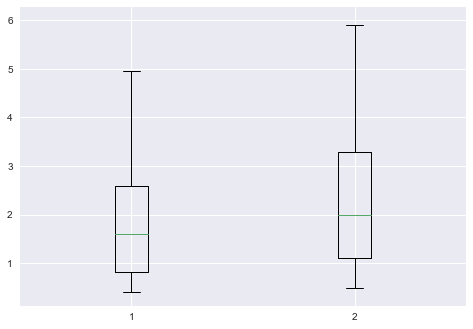

In [2]:
# per avere dei numeri visivamente non troppo grandi:
my_df['Price'] = my_df['Price']/1000000 # ora il prezzo è espresso in milioni di dollari

y_TownA = my_df.query('Town == "A"')['Price']
y_TownB = my_df.query('Town == "B"')['Price']

data = [y_TownA, y_TownB]

plt.figure().add_subplot(111).boxplot(data)

In [3]:
y = my_df['Price']
x = my_df.drop('Price', 1)
x['constant'] = 1

## Test per la differenza tra medie tramite regressione

Per testare se la differenza tra le medie dei prezzi delle case delle due città sia uguale a zero, possiamo adottare un modello di regressione in cui la variabile di risposta è il prezzo, mentre il predittore è una variabile indicatrice (*dummy*), la quale assume valore 0 se la casa è situata nella città A e valore 1 se la casa è situata nella città B (volendo, potremmo codificare al contrario, ma non cambierebbe nulla). Così facendo, la costante indicherà il prezzo medio delle case della citta A (categoria *baseline*), mentre il coefficiente associato alla *dummy* stimerà la differenza tra il prezzo medio delle case della città B ed il prezzo medio delle case della città A. Se tale coefficiente fosse diverso da zero al livello della popolazione, allora potremmo concludere che vi è una differenza significativa tra i prezzi nelle due città.

In [4]:
# creiamo la dummy per 'Town'
x['Town'] = pd.get_dummies(x['Town'])['B']

Poiché dal confronto tra i boxplots si evince una certa differenza in variabilità nei due gruppi, è meglio fare un fit con correzione di White per tener conto di una possibile violazione di omoschedasticità.

In [5]:
sm.OLS(y, x).fit(cov_type = 'HC3').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                   0.07308
Date:                Wed, 25 Oct 2017   Prob (F-statistic):              0.788
Time:                        09:24:35   Log-Likelihood:                -79.172
No. Observations:                  42   AIC:                             162.3
Df Residuals:                      40   BIC:                             165.8
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Town           0.1396      0.516      0.270      0.787      -0.873       1.152
constant       2.1775      0.396      5.499      0.000       1.401       2.954
==============================================================================
Omnibus:                        6.448   Durbin-Watson:                   0.022
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                6.144
Skew:                           0.936   Prob(JB):                       0.0463
Kurtosis:                       2.932   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [6]:
# la costante è uguale alla media dei prezzi in A:
np.mean(y_TownA)

2.1774619047619046

In [7]:
# il coefficiente per Town è uguale a media_B - media_A:
np.mean(y_TownB) - np.mean(y_TownA)

0.1396142857142859

**Il coefficiente per _Town_ indica che le case nella città B costano in media 139614 dollari in più. Tuttavia, tale coefficiente non risulta significativo, quindi non possiamo concludere che tale differenza sia davvero diversa da zero al livello della popolazione.**

## Test *t* per la differenza tra medie 

Il modo più standard per verificare se due gruppi differiscano o meno in media è tramite il classico test *t*. In questo caso, data la possibile eteroschedasticità, utilizzeremo un test di Welch (scelta più frequente), il quale non assume che le varianze dei due gruppi siano uguali.

In [8]:
from scipy import stats

stats.ttest_ind(y_TownB, y_TownA, equal_var = False)

Ttest_indResult(statistic=0.2770136373791327, pvalue=0.78324009161895258)

Il *p*-value non differisce granché da quello ottenuto tramite regressione: non possiamo rifiutare l'ipotesi nulla che le due città abbiano prezzi delle abitazioni in media uguali. 

## Equivalenza tra test *t* e regressione sotto l'assunzione di omoschedasticità

Nel caso in cui facessimo un fit del modello di regressione senza correzione di White e utilizzassimo un test *t* ipotizzando varianze uguali per le due città, avremmo esattamente gli stessi risultati in termini di statistica *t* e *p*-value. I due approcci sono infatti perfettamente equivalenti.

In [9]:
sm.OLS(y, x).fit().t_test('Town')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1396      0.504      0.277      0.783      -0.879       1.158

In [10]:
stats.ttest_ind(y_TownB, y_TownA, equal_var = True)

Ttest_indResult(statistic=0.2770136373791327, pvalue=0.78319618484446818)